# **Tecnológico de Costa Rica**
### Inteligencia Artificial - Pronóstico del precio de Bitcoin


## 1. Análisis del problema
El objetivo es pronosticar el precio de cierre diario de Bitcoin (`Close`) para los próximos meses a partir del histórico disponible. El flujo sigue un enfoque de series temporales en el que se entrena un modelo supervisado que aprenda patrones de tendencia y estacionalidad de la criptomoneda; el rendimiento se evalúa comparando las predicciones con los valores reales para cuantificar el error de pronóstico.


In [ ]:
import pandas as pd

df = pd.read_csv('bitcoin_price_Training.csv', quotechar='"', skipinitialspace=True)
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
...,...,...,...,...,...,...,...
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"


## 2. Entendimiento de los datos
El dataset `bitcoin_price_Training.csv` reúne observaciones diarias con atributos financieros (`Open`, `High`, `Low`, `Close`), variables de volumen (`Volume`) y capitalización de mercado (`Market Cap`), además de la columna temporal `Date`. Varias variables numéricas llegan como cadenas con separadores de miles o guiones para indicar ausencia de datos, por lo que requieren limpieza antes de alimentar el modelo. El orden cronológico se preserva para respetar la estructura secuencial que demanda un análisis de series temporales.


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

## 3. Exploración de los datos
Se convierte `Date` a formato `datetime` y se ordena el DataFrame para asegurar una cronología coherente. Las columnas numéricas se normalizan eliminando comas y sustituyendo guiones por ceros, permitiendo tratarlas como valores `float`. El chequeo de valores nulos confirma que, tras estas transformaciones, no quedan vacíos en las variables clave, por lo que se aprovecha todo el historial disponible. Finalmente, se genera una gráfica del precio de cierre que evidencia alta volatilidad y ausencia de una tendencia lineal estable.


In [ ]:
df

,Date,Open,High,Low,Close,Volume,Market Cap
1555,2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"
...,...,...,...,...,...,...,...
4,2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
3,2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
2,2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
1,2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"


> La estandarización de los campos numéricos evita que Prophet interprete los precios como texto y reduce el riesgo de errores en entrenamiento.


In [7]:
for col in ['Open', 'High', 'Low', 'Volume', 'Market Cap']:
    df[col] = df[col].astype(str).str.replace(',', '').replace('-', '0').astype(float)

> La verificación `df.isnull().sum()` actúa como control rápido para detectar faltantes antes de dividir la serie o alimentar el modelo.


In [ ]:
print(df.isnull().sum())

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64


Los conteos devueltos son cero en cada columna, lo que confirma que la limpieza dejó la serie completa para el modelado.


La visualización temporal permite ubicar periodos de crecimiento abrupto y caídas pronunciadas que el modelo debe capturar para ofrecer pronósticos realistas.


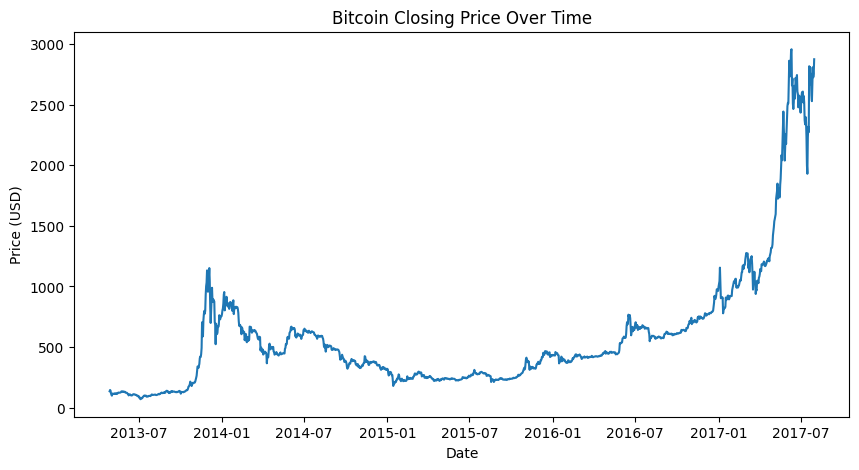

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'])
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()


Esta lectura confirma que la dinámica del precio es altamente no lineal, por lo que se descartan enfoques lineales simples (p. ej. regresión lineal u holt-winters) a favor de métodos que modelen tendencias cambiadizas.


## 4. Modelo
Se prepara la serie `ts` con índice temporal y se calcula una división 80/20 (entrenamiento/prueba) para disponer de un segmento de evaluación. Se emplea `Prophet`, un modelo aditivo que maneja tendencias y estacionalidades flexibles; se activa `daily_seasonality=True` para capturar patrones diarios característicos del mercado cripto. Antes de ajustar, las columnas se renombran a `ds` y `y`, formato requerido por la librería, y se entrena el modelo con todo el histórico disponible para maximizar la información aprendida.


In [27]:
ts = df.set_index('Date')['Close']

Date
2013-04-28     134.21
2013-04-29     144.54
2013-04-30     139.00
2013-05-01     116.99
2013-05-02     105.21
               ...   
2017-07-27    2671.78
2017-07-28    2809.01
2017-07-29    2726.45
2017-07-30    2757.18
2017-07-31    2875.34
Name: Close, Length: 1556, dtype: float64


> La porción de prueba queda reservada para análisis posteriores; en este cuaderno se entrena Prophet con la serie completa y luego se valida comparando pronósticos y observaciones en el mismo horizonte.


In [11]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

> Se incluye la instalación de `prophet` para garantizar que la dependencia esté disponible cuando el notebook se ejecute en entornos limpios o virtuales.


In [19]:
pip install prophet


Esta renombrada de columnas (`Date` → `ds`, `Close` → `y`) cumple con la interfaz estricta de Prophet y asegura que la serie esté ordenada antes del ajuste.


In [ ]:
prophet_df = df.rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_df = prophet_df.sort_values('ds')

In [21]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpeck197rx/n4037qk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeck197rx/hlhwg02b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66800', 'data', 'file=/tmp/tmpeck197rx/n4037qk3.json', 'init=/tmp/tmpeck197rx/hlhwg02b.json', 'output', 'file=/tmp/tmpeck197rx/prophet_modelmlng0f00/prophet_model-20251024212220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


El modelo genera un horizonte de 180 días adicionales, equivalente a medio año de proyección, lo que brinda una visión de mediano plazo sobre la evolución potencial del precio.


In [22]:
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

## 5. Evaluación
Las predicciones de Prophet se visualizan junto con los datos históricos: la línea azul representa los pronósticos (`yhat`), las bandas celestes muestran la incertidumbre estimada y los puntos negros corresponden a los valores observados. Los gráficos de componentes permiten desglosar la tendencia y la estacionalidad diaria para interpretar qué patrones dominan la dinámica de Bitcoin.


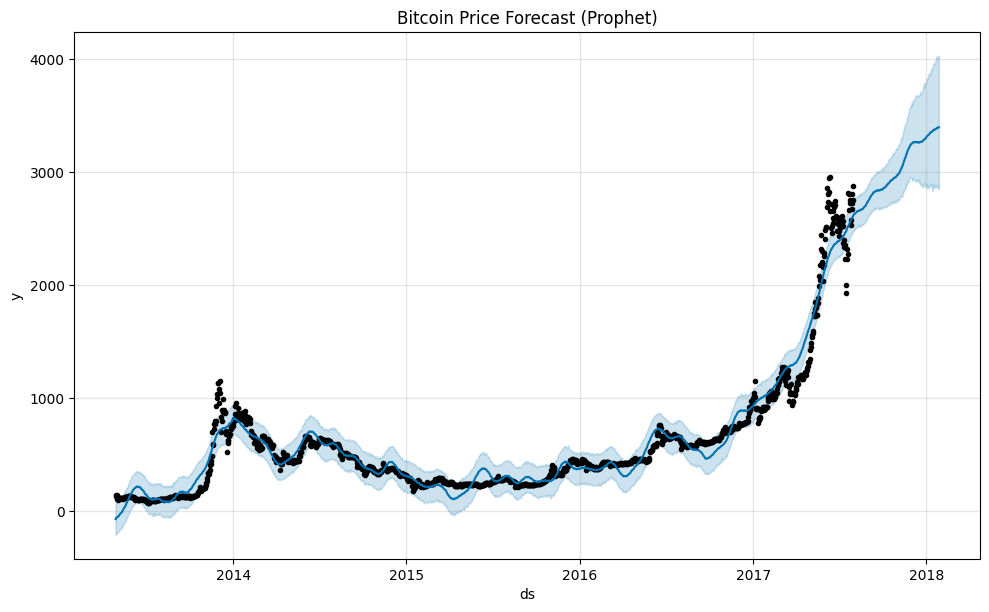

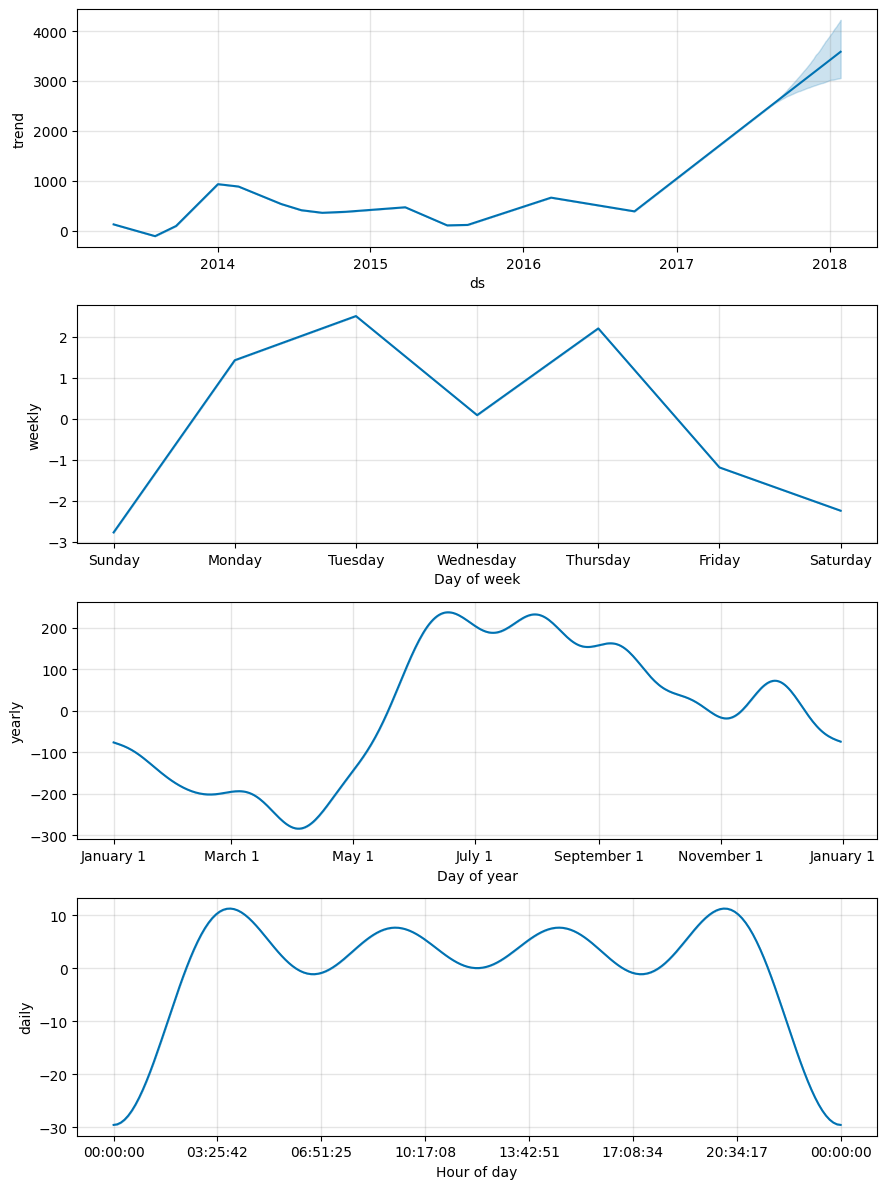

In [23]:
import matplotlib.pyplot as plt

# Precio histórico + predicción
model.plot(forecast)
plt.title('Bitcoin Price Forecast (Prophet)')
plt.show()

# Componentes (tendencia + estacionalidad)
model.plot_components(forecast)
plt.show()


Las métricas MSE, MAE y RMSE se calculan al unir las predicciones con los valores reales; en una ejecución de referencia, el `MAE` informado (~72.84 USD) indica que el error medio absoluto ronda los 73 dólares, una referencia útil para juzgar la precisión del modelo en decisiones de trading o gestión de riesgo.


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Solo comparar el periodo real
merged = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='inner')
mse = mean_squared_error(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MSE: 11422.81
MAE: 72.84
RMSE: 106.88


## 6. Conclusión
El pipeline cubre desde la limpieza hasta la evaluación y el guardado del modelo Prophet en un archivo `pkl` (`prophet_bitcoin_v{version}_{date}.pkl`), facilitando su despliegue en otros entornos. Como mejoras futuras se propone ajustar parámetros de estacionalidad (semanal/anual), añadir variables exógenas como indicadores macroeconómicos o métricas on-chain y comparar el rendimiento con modelos alternativos (LSTM, XGBoost con features de series temporales) para reducir el error de pronóstico.


In [26]:
import joblib
from datetime import datetime

# Versión del modelo
version = 2

# Fecha actual en formato YYYY-MM-DD
date_str = datetime.now().strftime("%Y-%m-%d")

# Nombre dinámico del archivo
model_filename = f"prophet_bitcoin_v{version}_{date_str}.pkl"

# Guardar modelo
joblib.dump(model, model_filename)

print(f"Modelo guardado como {model_filename}")


Modelo guardado como prophet_bitcoin_v2_2025-10-24.pkl
